#  Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?


# Create a Jupyter notebook with your models. 

First let's write basic import statements for libraries and the dataset:

In [1]:
## Import statements
from itertools import permutations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox, jarque_bera, normaltest
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNetCV, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from IPython.display import Markdown, display
import scipy
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')


# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
def printmd(string):
    "prints text in bold"
    display(Markdown(string))

import warnings
warnings.filterwarnings(action="ignore")


postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


Next, let's define functions that may be used repeatedly through this experiment:

In [2]:
# Function definitions
def classify_nbr(saleprice):
    """ puts houses in preset neighborhood bins """
    
    nbr_class = {0:'saleprice < 120000',
                 1:'saleprice >= 120000 and saleprice < 200000',
                 2:'saleprice >= 200000 and saleprice < 300000',
                 3:'saleprice >= 300000'}
    for class_level in nbr_class.keys():
        if eval(nbr_class[class_level]):
            return class_level

df['neighborhood_class'] = df['saleprice'].apply(classify_nbr)


def log_prep(temp_df):
    """takes in the chosen temp_df for the model and outputs X & Y with saleprice log-transformed"""
    
    # Log-transform salesprice values & drop saleprice
    temp_df['saleprice_log'] = np.log(temp_df['saleprice'])
    temp_df.drop(columns=['saleprice'],inplace=True)
    
    # designate features
    features = list(temp_df.columns)
    features.remove('saleprice_log')
    print('features (len: {}): {}\ntarget: {}'.format(len(features),{i for i in features},list(set(set(temp_df.columns)-set(features)))))

    # X & Y
    X = temp_df[features]
    Y = temp_df['saleprice_log']
    return X,Y


def optimize_ElasticNet(x, y, title):
    """
        Scores & plots prediction of an ElasticNetCV object
        and uses its best hyperparameter values to return
        an ElasticNet regression object.
    """
    clf = ElasticNetCV(max_iter=2000, cv=10, l1_ratio = [.1, .5,.7, .9, .95, .99, 1], normalize=True)
    clf.fit(x, y)
    print ("Score", clf.score(x, y))
    print(clf.get_params)
    pred = clf.predict(x)
    plt.title("Scatter plot of prediction and " + title)
    plt.xlabel("Prediction")
    plt.ylabel("Target")
    plt.scatter(y, pred)
    
    # Show perfect fit line
    plt.plot(y, y, label="Perfect Fit")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return ElasticNet(alpha=clf.alpha_,l1_ratio=clf.l1_ratio_,fit_intercept=clf.fit_intercept,normalize=clf.normalize,copy_X=clf.copy_X,tol=clf.tol,positive=True)    


def plot_showErrors(y_test,y_preds,title):
    # plot results against actual values
    plt.scatter(y_test, y_preds)
    plt.plot(y_test, y_test)
    plt.xlabel("true values")
    plt.ylabel("predicted values")
    plt.title("House prices: true vs. predicted values")
    plt.show()
    # Measure model errors
    print("{} MODEL ERRORS\n**********************************".format(title.upper()))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
    print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))
    print(('*'*20))


Now we get back to the data we imported. Let's start by cleaning and feature-selecting data to prepare for both models:

features (len: 6): {'garagecars', 'fullbath', 'yearremodadd', 'yearbuilt', 'neighborhood_class', 'totalbsmtsf'}
target: ['saleprice_log']
Score 0.8994460592179154
<bound method BaseEstimator.get_params of ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=2000,
             n_alphas=100, n_jobs=None, normalize=True, positive=False,
             precompute='auto', random_state=None, selection='cyclic',
             tol=0.0001, verbose=0)>


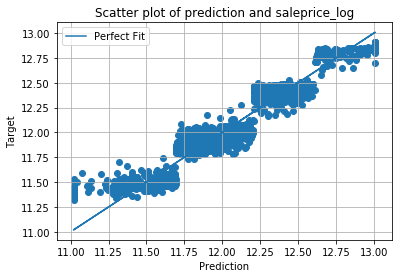

In [3]:
# MODEL PREPARATION
#count missing values
missing_vals = (df.isnull().sum()/len(df)).sort_values(ascending=False)

# keep column names that do have them
missing_vals = missing_vals[missing_vals > 0]

# data types
missValDTypes = df[missing_vals.index.to_list()].dtypes

# Create a dictionary containing the value to replace missing values in each column
fill_with = {'garageyrblt': 0, 'garagequal': 'TA', 'garagecond': 'TA', 'garagefinish': 'Unf','garagetype':'No',
             'bsmtexposure':'No','bsmtfintype2':'Unf','bsmtfintype1':'Unf','bsmtqual':'TA','bsmtcond':'TA',
             'masvnrarea':0,'masvnrtype':'None','electrical':'SBrkr'}

# Also, fill first 5 columns with 0 for missing values
fill_with.update({key:0 for key in missing_vals[:5].index.to_list()})

if 'id' in df.columns:
    df = df.drop(columns=['id'])
df = df.fillna(value=fill_with)

# Select features & split dataset
features = ['saleprice', 'neighborhood_class', 'garagecars', 'totalbsmtsf', 'fullbath',
            'yearbuilt', 'yearremodadd']
temp_df = df[features]

for i in ['saleprice', 'totalbsmtsf']:
    temp_df[i] = winsorize(temp_df[i], (0.01, 0.01))

X, Y = log_prep(temp_df)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


## Linear regression
model_1 = ElasticNetCV(l1_ratio=0.5, eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize=False, 
                       precompute='auto', max_iter=1000, tol=0.0001, cv=10, copy_X=True, verbose=0, n_jobs=-1, 
                       positive=False, random_state=None, selection='cyclic')
hParams = model_1.__dict__

# Initiate ElasticNet model based on ElasticNetCV
optimized_OLS = optimize_ElasticNet(X, Y,"saleprice_log")

Using the function defined above, *optimize_ElasticNet()*, we created a model with the best alpha and other hyperparameters. Now we fit it and use the *plot_showErrors()* function to plot prediction and show error metrics, which will also apply to the KNN regressor we'll initiate:

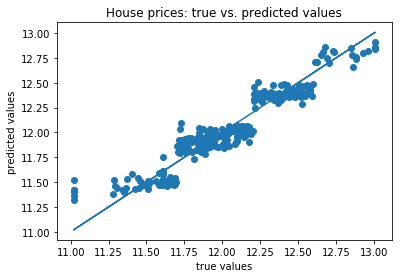

OLS MODEL ERRORS
**********************************
Mean absolute error of the prediction is: 0.10050328822600745
Mean squared error of the prediction is: 0.015919634309672772
Root mean squared error of the prediction is: 0.12617303321103432
Mean absolute percentage error of the prediction is: 0.8402977612170466
********************


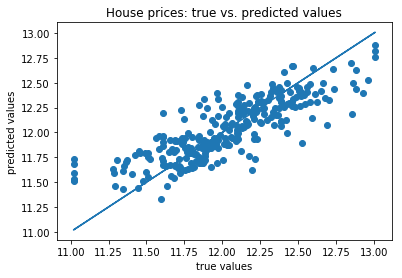

KNN MODEL ERRORS
**********************************
Mean absolute error of the prediction is: 0.1683554760471893
Mean squared error of the prediction is: 0.04844019257828976
Root mean squared error of the prediction is: 0.2200913278125464
Mean absolute percentage error of the prediction is: 1.4048043007784465
********************


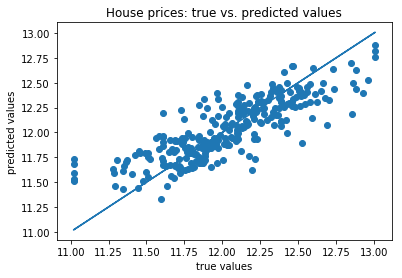

KNN_MINKOWSKI MODEL ERRORS
**********************************
Mean absolute error of the prediction is: 0.1683554760471893
Mean squared error of the prediction is: 0.04844019257828976
Root mean squared error of the prediction is: 0.2200913278125464
Mean absolute percentage error of the prediction is: 1.4048043007784465
********************


In [4]:
# Fit our ElasticNet model, show its prediction and model valuation metrics
optimized_OLS.fit(X_train,y_train)
plot_showErrors(y_test,optimized_OLS.predict(X_test),'ols')


# KNN Regressor
gridOv_params = {'n_neighbors':[6,9,10,12,14,15,16,18],
                 'weights':['uniform','distance'],
                 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                 'leaf_size':[5,9,20,30,45,50,55,90],
                 'metric':['minkowski','manhattan','euclidean'],
                 'n_jobs':[-1]
                }
clf0 = GridSearchCV(KNeighborsRegressor(),param_grid=gridOv_params,n_jobs=-1)
clf0.fit(X_train,y_train)
gridOv_params = clf0.best_params_
clf0 = KNeighborsRegressor(algorithm=gridOv_params['algorithm'],
                           leaf_size=gridOv_params['leaf_size'],
                           metric=gridOv_params['metric'],
                           n_jobs=gridOv_params['n_jobs'],
                           n_neighbors=gridOv_params['n_neighbors'],
                           weights=gridOv_params['weights'])
clf0.fit(X_train,y_train)
plot_showErrors(y_test,clf0.predict(X_test),'knn')



clf1 = KNeighborsRegressor(algorithm=gridOv_params['algorithm'],
                           leaf_size=gridOv_params['leaf_size'],
                           metric='minkowski',
                           n_jobs=gridOv_params['n_jobs'],
                           n_neighbors=gridOv_params['n_neighbors'],
                           weights=gridOv_params['weights'])
clf1.fit(X_train,y_train)

plot_showErrors(y_test,clf0.predict(X_test),'knn_minkowski')

# At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. 

First thing we notice is the two KNN models are no different from each other in terms of model quality. They both have the same metrics; this can be due to the first model automatically choosing *minkowski* from GridSearch or to one of the distance metrics being a default to one one of the other parameters we did not explicitly specify.

What's more important, however, is the difference between using KNN and the enhanced OLS (ElasticNet). The ElasticNet model was enhanced by running it with several sets of parameters -including alpha- and deciding on the best one. Its prediction is shaped in groups that are close to the true values but still are within a known shape (stair-like-origanized semi-rectangles). This known shape of prediction can lack precision in predicting continuous variables because it will avoid predicting certain values that are closer to true values but fall outside the stair shape.

KNN, on the other hand, has a smoother prediction line that more closely matches a regression line, which is more favorable in case the prediction outcome precision is more emphasized. KNN was also enhanced, but through running GridSearchCV on a wider possibility of hyperparemeter sets. The *n* number of neighbors was chosen with respect to the output's best fit and alignmet with the inclined fit line.

This makes KNN a more reliable regression model for this dataset, since it is more likely to predict prices accurately.

# Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. 

If the objective of prediction was to place datapoints -or *house features*- within groups or ranges of prices rather than a specific number, then ElasticNet would have been a good model for this task, because it would estimate predictions to fall within certain buckets rather than absolute prediction that may fall on any point on the fit line.

# Lastly, try to note what it is about the data that causes the better model to outperform the weaker model.

It may be due to the weaker model, *ElasticNet*, choosing L2 regularization, or *Ridge* regression. The stair-like prediction output includes gap points (the gaps between the stairs) resulting from the limitations of the algorithm itself.